In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# 1. 数据加载与预处理
df = pd.read_csv('D:/aiwork/green_tripdata_2016-12.csv')
# 选择2016年1月的数据
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])

df = df[(df['lpep_pickup_datetime'].dt.year == 2016) & (df['lpep_pickup_datetime'].dt.month == 12)]

# 清洗数据：移除缺失值或异常值
df = df.dropna(subset=['trip_distance', 'fare_amount', 'passenger_count', 'PULocationID', 'DOLocationID'])
df = df[(df['trip_distance'] > 0) & (df['fare_amount'] > 0) & (df['passenger_count'] > 0)]

# 特征工程
df['pickup_hour'] = df['lpep_pickup_datetime'].dt.hour
df['pickup_dayofweek'] = df['lpep_pickup_datetime'].dt.dayofweek
df['pickup_month'] = df['lpep_pickup_datetime'].dt.month

df['dropoff_hour'] = df['lpep_dropoff_datetime'].dt.hour
df['dropoff_dayofweek'] = df['lpep_dropoff_datetime'].dt.dayofweek

# 计算行程时间
df['trip_duration'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60.0

# 选择特征和目标变量
features = ['pickup_hour', 'pickup_dayofweek', 'pickup_month', 'dropoff_hour', 'dropoff_dayofweek', 'passenger_count', 'trip_distance']
target = 'trip_duration'

X = df[features]
y = df[target]

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分数据集：训练集70%、验证集15%、测试集15%
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [3]:
# 2. 构建神经网络模型
model = models.Sequential()

# 输入层和第一个隐藏层
model.add(layers.Dense(512, input_dim=X_train.shape[1], activation='relu'))

# 第二个隐藏层
model.add(layers.Dense(512, activation='relu'))

# 输出层（回归任务，只有一个神经元）
model.add(layers.Dense(1))

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 设置早停策略
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


C:\Users\30579\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# 3. 训练模型
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/10
13171/13171 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 2906.2656 - val_loss: 62.5980
Epoch 2/10
13171/13171 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - loss: 55.0203 - val_loss: 41.8130
Epoch 3/10
13171/13171 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 46.2131 - val_loss: 39.9608
Epoch 4/10
13171/13171 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 43.3103 - val_loss: 41.9022
Epoch 5/10
13171/13171 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 44.8623 - val_loss: 49.6443
Epoch 6/10
13171/13171 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 42.9245 - val_loss: 29.2420
Epoch 7/10
13171/13171 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 36.7765 - val_loss: 70.0358
Epoch 8/10
13171/13171 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 36.8871 - val_loss: 30.1947
Epoch 9/10
13171/13171 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 36.4439 - val_loss: 40.0731
Epoch 10/10
13171/13171 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 36.5688 - val_loss: 33.3843


In [5]:
# 4. 使用测试集进行评估
y_pred = model.predict(X_test)
# 计算平均绝对误差（MAE）
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

5645/5645 ━━━━━━━━━━━━━━━━━━━━ 6s 974us/step
Mean Absolute Error (MAE): 3.0964589540636007


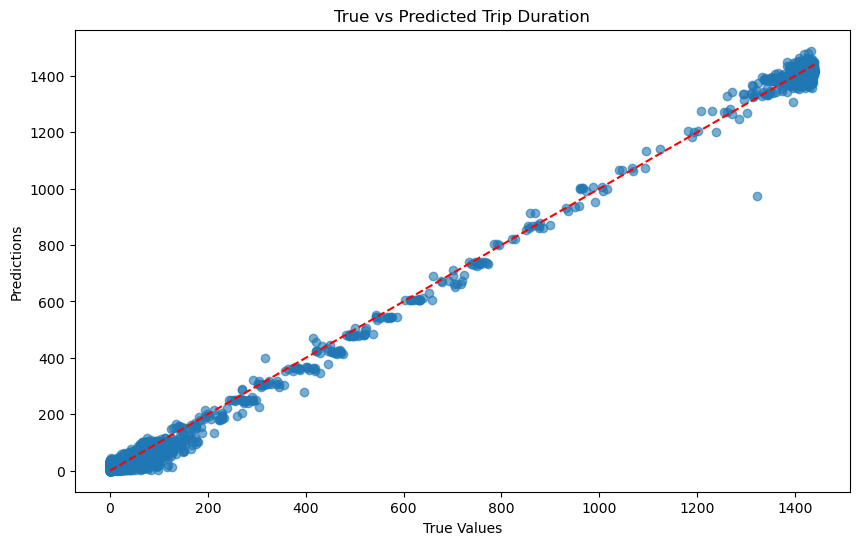

In [6]:
# 5. 可视化预测结果与真实值对比
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')  # 线性对比
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Trip Duration')
plt.show()

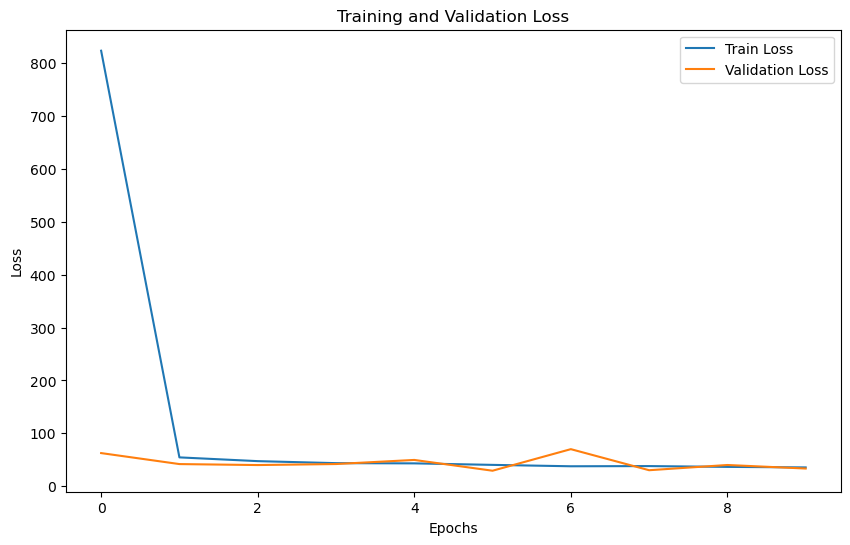

In [7]:
# 绘制训练和验证损失曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()